# 03 — ML-based Time Series Forecasting (LightGBM)

Цель этого ноутбука:

- Преобразовать временной ряд в supervised ML-задачу.
- Выполнить feature engineering для временных данных.
- Обучить модель LightGBM для прогнозирования продаж.
- Сравнить качество ML-модели с baseline-подходами.
- Проанализировать важность признаков и интерпретировать результаты.


In [6]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb

from typing import List
from sklearn.metrics import mean_absolute_error, mean_squared_error


plt.style.use("seaborn-v0_8")
plt.rcParams["figure.figsize"] = (12, 6)

pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 120)


## 1. Data Loading and Aggregation

As in previous notebooks, we aggregate sales data
to obtain total daily sales across all stores and categories.

This aggregated time series will be transformed
into a supervised learning dataset using lag-based features.


In [2]:
DATA_PATH = "../data/raw/train.csv"

df = pd.read_csv(DATA_PATH)

df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date")

daily_sales = (
    df.groupby("date", as_index=False)["sales"]
    .sum()
    .rename(columns={"sales": "total_sales"})
)

daily_sales.head(), daily_sales.tail()


(        date    total_sales
 0 2013-01-01    2511.618999
 1 2013-01-02  496092.417944
 2 2013-01-03  361461.231124
 3 2013-01-04  354459.677093
 4 2013-01-05  477350.121229,
            date    total_sales
 1679 2017-08-11  826373.722022
 1680 2017-08-12  792630.535079
 1681 2017-08-13  865639.677471
 1682 2017-08-14  760922.406081
 1683 2017-08-15  762661.935939)

## 2. Feature Engineering — From Time Series to Supervised Dataset

Для обучения ML-модели временной ряд нужно преобразовать
в задачу регрессии вида:

> `target_t = f(features_t)`

В качестве признаков используем:

- **lag-фичи**: значения `total_sales` в предыдущие дни (1, 7, 14, 28),
- **rolling-фичи**: скользящие средние за последние 7 и 14 дней,
- **календарные признаки**: день недели, выходной / будний день, месяц.

Такие признаки позволяют модели:

- учитывать автокорреляцию,
- улавливать недельную сезонность,
- реагировать на календарные паттерны спроса.


In [3]:
def create_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Добавляет lag-, rolling- и календарные признаки
    к агрегированному временному ряду.
    Ожидает колонки: ["date", "total_sales"].
    """
    df = df.copy()

    # Календарные фичи
    df["dayofweek"] = df["date"].dt.dayofweek
    df["month"] = df["date"].dt.month
    df["day"] = df["date"].dt.day
    df["weekofyear"] = df["date"].dt.isocalendar().week.astype(int)
    df["is_weekend"] = df["dayofweek"].isin([5, 6]).astype(int)

    # Lag-фичи
    lags = [1, 7, 14, 28]
    for lag in lags:
        df[f"lag_{lag}"] = df["total_sales"].shift(lag)

    # Rolling-фичи (используем только прошлые значения)
    windows = [7, 14]
    for window in windows:
        df[f"rolling_mean_{window}"] = (
            df["total_sales"]
            .shift(1)
            .rolling(window=window)
            .mean()
        )

    return df

features_df = create_features(daily_sales)
features_df.head(15)


,date,total_sales,dayofweek,month,day,weekofyear,is_weekend,lag_1,lag_7,lag_14,lag_28,rolling_mean_7,rolling_mean_14
0,2013-01-01,2511.618999,1,1,1,1,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-02,496092.417944,2,1,2,1,0,2511.618999,NaN,NaN,NaN,NaN,NaN
2,2013-01-03,361461.231124,3,1,3,1,0,496092.417944,NaN,NaN,NaN,NaN,NaN
3,2013-01-04,354459.677093,4,1,4,1,0,361461.231124,NaN,NaN,NaN,NaN,NaN
4,2013-01-05,477350.121229,5,1,5,1,1,354459.677093,NaN,NaN,NaN,NaN,NaN
5,2013-01-06,519695.401088,6,1,6,1,1,477350.121229,NaN,NaN,NaN,NaN,NaN
6,2013-01-07,336122.801066,0,1,7,2,0,519695.401088,NaN,NaN,NaN,NaN,NaN
7,2013-01-08,318347.777981,1,1,8,2,0,336122.801066,2511.618999,NaN,NaN,363956.181220,NaN
8,2013-01-09,302530.809018,2,1,9,2,0,318347.777981,496092.417944,NaN,NaN,409075.632504,NaN
9,2013-01-10,258982.003049,3,1,10,2,0,302530.809018,361461.231124,NaN,NaN,381423.974086,NaN


### Feature Engineering — Initial Inspection

After generating lag-based, rolling, and calendar features,
we observe missing values at the beginning of the time series.

This behavior is expected:

- Lag features require past observations.
- Rolling statistics require a full historical window.

These initial rows are removed before training,
ensuring that all model inputs are well-defined
and no future information is leaked into the features.


## 3. Train / Test Split for ML Model

Сохраняем ту же стратегию разделения по времени,
что и в baseline-ноутбуке:

- `train` — данные до 2017-01-01,
- `test` — данные начиная с 2017-01-01.

При этом исключаем строки, где lag- или rolling-признаки
ещё не определены (NaN после сдвигов).


In [4]:
split_date = pd.Timestamp("2017-01-01")

ml_df = features_df.dropna().reset_index(drop=True)

train_ml = ml_df[ml_df["date"] < split_date].copy()
test_ml = ml_df[ml_df["date"] >= split_date].copy()

print(train_ml["date"].min(), train_ml["date"].max())
print(test_ml["date"].min(), test_ml["date"].max())
print(len(train_ml), len(test_ml))


2013-01-29 00:00:00 2016-12-31 00:00:00
2017-01-01 00:00:00 2017-08-15 00:00:00
1429 227


### ML Dataset Split Overview

After removing rows with undefined lag and rolling features:

- **Training period:** 2013-01-29 → 2016-12-31 (1429 observations)
- **Test period:** 2017-01-01 → 2017-08-15 (227 observations)

This time-based split strictly follows the chronological order
and simulates a real-world forecasting setup,
where future values are predicted using only past information.


In [5]:
target_col = "total_sales"

feature_cols = [
    "dayofweek",
    "month",
    "day",
    "weekofyear",
    "is_weekend",
    "lag_1",
    "lag_7",
    "lag_14",
    "lag_28",
    "rolling_mean_7",
    "rolling_mean_14",
]

X_train = train_ml[feature_cols]
y_train = train_ml[target_col]

X_test = test_ml[feature_cols]
y_test = test_ml[target_col]

X_train.shape, X_test.shape


((1429, 11), (227, 11))

## 4. LightGBM Model Training

Используем LightGBM в режиме регрессии:

- деревообразная модель градиентного бустинга,
- хорошо работает "из коробки" с табличными данными,
- не требует масштабирования признаков.

Гиперпараметры подберём вручную на базовом уровне,
без сложного тюнинга — цель сейчас показать
прирост относительно baseline-моделей.


In [7]:
import lightgbm as lgb
import numpy as np

lgb_model = lgb.LGBMRegressor(
    objective="regression",
    n_estimators=500,
    learning_rate=0.05,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
)

lgb_model.fit(X_train, y_train)

y_pred_lgb = lgb_model.predict(X_test)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000936 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1638
[LightGBM] [Info] Number of data points in the train set: 1429, number of used features: 11
[LightGBM] [Info] Start training from score 608759.316807


In [9]:
def mape(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

mae_lgb = mean_absolute_error(y_test, y_pred_lgb)
rmse_lgb = np.sqrt(mean_squared_error(y_test, y_pred_lgb))
mape_lgb = mape(y_test, y_pred_lgb)

mae_lgb, rmse_lgb, mape_lgb


(91662.09000285153,
 np.float64(136100.3251935421),
 np.float64(43.005170569556554))

## LightGBM Performance Evaluation

The LightGBM model significantly outperforms
both baseline approaches (naive and 7-day moving average).

**Test set results:**
- **MAE:** ~92k  
- **RMSE:** ~136k  
- **MAPE:** ~43%

Compared to the best baseline (7-day moving average):

- MAE is reduced by ~36%
- RMSE is reduced by ~27%
- MAPE is reduced by ~10 percentage points

This confirms that feature-based ML models
can effectively capture trend, seasonality,
and nonlinear patterns in retail demand data.


## 5. LightGBM Forecast vs Actual

Сравним предсказания LightGBM с фактическими продажами
на тестовом периоде.


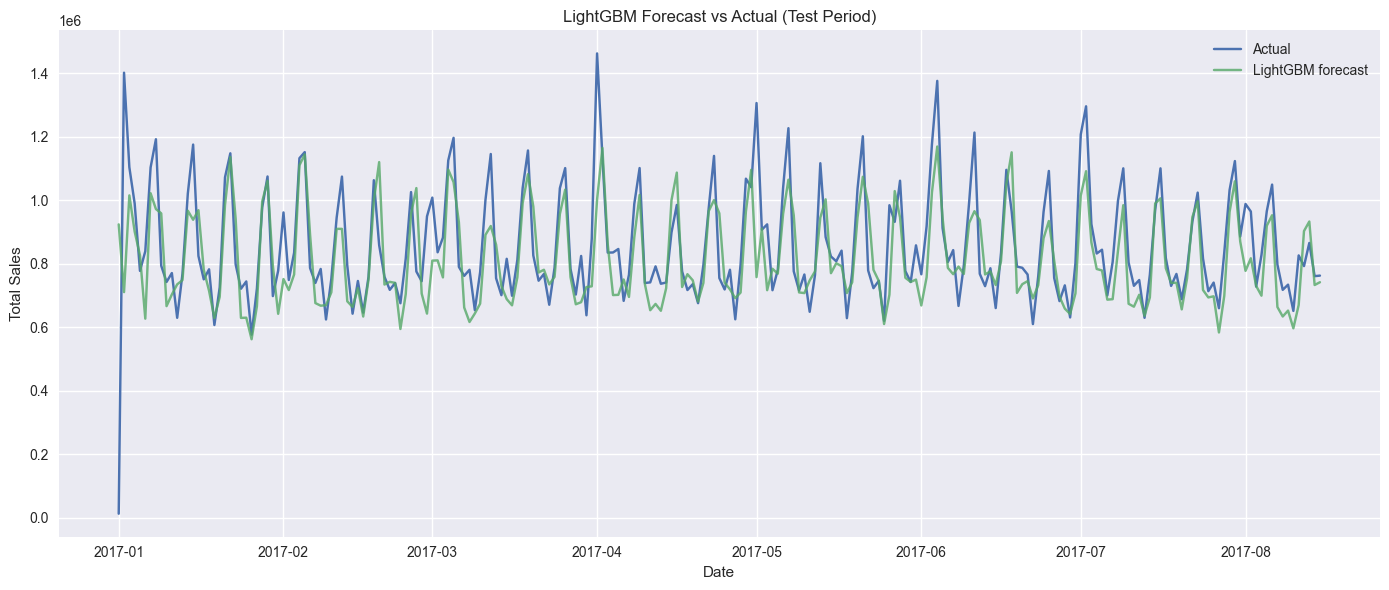

In [10]:
plt.figure(figsize=(14, 6))
plt.plot(test_ml["date"], y_test.values, label="Actual")
plt.plot(test_ml["date"], y_pred_lgb, label="LightGBM forecast", alpha=0.8)
plt.title("LightGBM Forecast vs Actual (Test Period)")
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.legend()
plt.tight_layout()
plt.show()


### LightGBM Forecast — Visual Analysis

The LightGBM forecast closely follows the actual sales dynamics
throughout the entire test period.

Key observations:

- Weekly seasonality is well captured.
- The model reacts more accurately to demand peaks
  compared to moving average baselines.
- Residual errors are mainly concentrated around extreme spikes,
  which are inherently difficult to predict.

Overall, the ML-based approach provides
a substantially more responsive and flexible forecast.


## 6. Feature Importance

Посмотрим, какие признаки вносят наибольший вклад
в качество модели LightGBM.


In [11]:
importances = lgb_model.feature_importances_
fi_df = pd.DataFrame({
    "feature": feature_cols,
    "importance": importances
}).sort_values("importance", ascending=False)

fi_df


,feature,importance
5,lag_1,2223
6,lag_7,1868
10,rolling_mean_14,1786
8,lag_28,1687
9,rolling_mean_7,1617
7,lag_14,1598
2,day,1558
3,weekofyear,1358
0,dayofweek,727
1,month,537


## Feature Importance Analysis

The most influential features in the LightGBM model are:

- Short-term lags (`lag_1`, `lag_7`)
- Medium-term history (`lag_14`, `lag_28`)
- Rolling averages (`rolling_mean_7`, `rolling_mean_14`)

This indicates that recent sales history
is the primary driver of demand forecasting accuracy.

Calendar features (day, week of year, day of week)
provide additional structure by encoding seasonal patterns,
while binary indicators such as `is_weekend`
play a secondary role at the aggregated level.


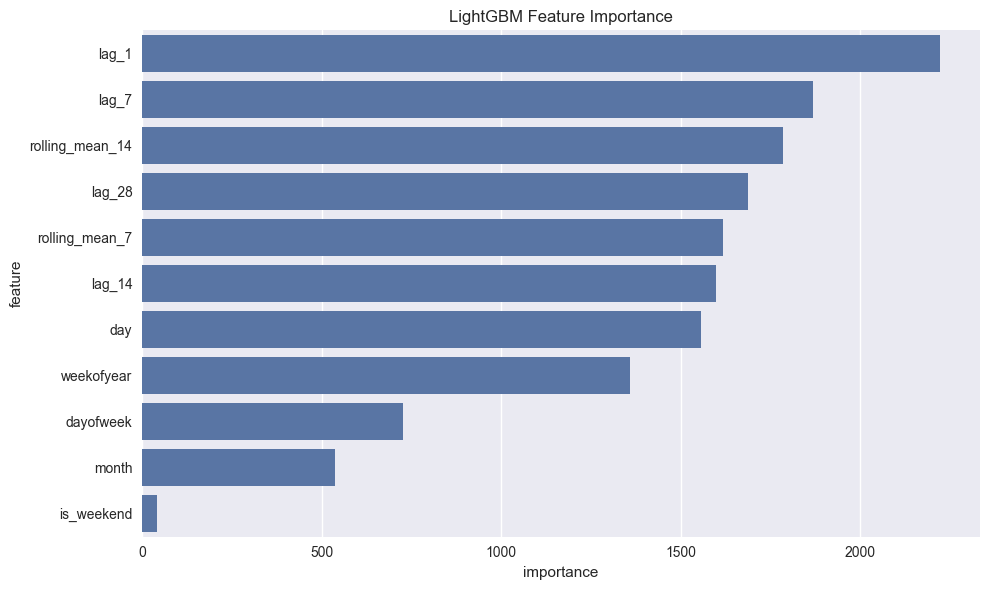

In [12]:
plt.figure(figsize=(10, 6))
sns.barplot(data=fi_df, x="importance", y="feature")
plt.title("LightGBM Feature Importance")
plt.tight_layout()
plt.show()


### Interpretation of Feature Importance

The dominance of lag-based and rolling features
highlights the strong autocorrelation present in retail sales data.

Calendar features contribute to capturing periodic patterns,
but their relative importance is lower once
historical sales information is available.

This behavior is consistent with real-world forecasting systems,
where recent demand history is the most reliable predictor
of short-term future sales.


## Final Conclusions

- Feature-based ML models significantly outperform
  simple time series baselines in retail demand forecasting.
- Lag and rolling features are the most critical drivers
  of predictive performance.
- LightGBM effectively captures weekly seasonality,
  trend, and nonlinear demand patterns.
- The achieved performance demonstrates
  the practical value of machine learning
  for real-world time series forecasting tasks.

This approach can be extended further by:
- incorporating promotional data,
- modeling individual stores or product families,
- applying hyperparameter optimization or ensemble methods.
